# STAT457 Final Project
Author: Simon Zhou
Date: 2020-4-11


## Introduction

### Brief Intro:
Reference: https://www.kaggle.com/c/whats-cooking-kernels-only/overview
Different countries have different cultural, different traditions and different eating habit. Some food could represent for the entire country. If people go to South Korea, they may eat Korean traditional food like Kimchi and korean jajangmyeon; if people go to North America, they may eat more hamburgers and steaks; if pepople go to China, they may eat chinese traditional food like hotpots and Beijing Roast Duck. Some of the strongest geographic and cultrual associations are highly related to a region's traditional local foods. In this project, I am asked to predict the category of a dish's cuisine given a list of ingredients that used in the dish. 

### Data Description:
Reference: https://www.kaggle.com/c/whats-cooking-kernels-only/data
I will use two datasets that provided by Yummly:
1. Training dataset is in JSON format and has three attriburtes: recipe ID(int), the type of cuisine(object/string), and the list of ingredients(object).
2. Test dataset only have two attributes: recipe ID and the list of ingredients. Both attributes have the same format as they appear in Training dataset.

### Data Policy:
Reference: https://developer.yummly.com/policies.html
1. This data will be only used in this project. I will not sell, resell this data to others.
2. I will not copy or modify this data for other use.


In [33]:
#Import required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import unidecode
import warnings
from joblib import Parallel, parallel_backend
import seaborn as sns
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
tqdm.pandas()
## Data modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import nltk
from nltk.stem import WordNetLemmatizer
%matplotlib inline
warnings.filterwarnings('ignore', category=FutureWarning)

In [1]:
!pip install wordcloud
!pip install unidecode

     |████████████████████████████████| 368kB 2.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 245kB 3.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
# read file 
train_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")
train_data.head(10)
#test_data.head(10)

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [6]:
train_data.info() # get basic describtion for the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [8]:
# Figure out how many types of cuisine in the training data
classes = train_data.cuisine.value_counts().unique()
len(classes)

20

There are 20 different and distinct classes in this training data. Therefore, the types of cuisine we predict in test data are within these 20 types.

## Exploratory Data Analysis & Visualization

In [8]:
train_ingredients = train_data["ingredients"] # merge all ingredients in training data
#train_ingredients
train_classes = train_data["cuisine"]
#train_classes
train_ingredients

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
5        [plain flour, sugar, butter, eggs, fresh ginge...
6        [olive oil, salt, medium shrimp, pepper, garli...
7        [sugar, pistachio nuts, white almond bark, flo...
8        [olive oil, purple onion, fresh pineapple, por...
9        [chopped tomatoes, fresh basil, garlic, extra-...
10       [pimentos, sweet pepper, dried oregano, olive ...
11       [low sodium soy sauce, fresh ginger, dry musta...
12       [Italian parsley leaves, walnuts, hot red pepp...
13       [ground cinnamon, fresh cilantro, chili powder...
14       [fresh parmesan cheese, butter, all-purpose fl...
15       [tumeric, vegetable stock, tomatoes, garam mas...
16       [greek yogurt, lemon curd, confectioners sugar.

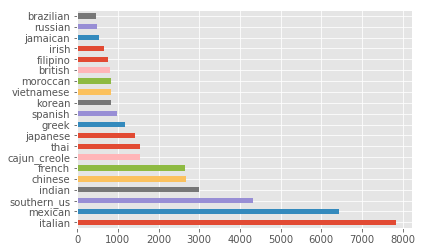

In [10]:
plt.style.use("ggplot")
train_classes.value_counts().plot(kind = "barh") # what types of cuisine have the most recipes in total

We can see that Italian, mexican and southern US are the top 3 cuisines in this dataset in terms of numbers of recipe

In [11]:
ingre_list = [] # ingedient list for this whole dataset, change 2d array to 1d
for i in range(len(train_ingredients)):
    ingre_list += train_ingredients[i]
ingre_list

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles',
 'plain flour',
 'ground pepper',
 'salt',
 'tomatoes',
 'ground black pepper',
 'thyme',
 'eggs',
 'green tomatoes',
 'yellow corn meal',
 'milk',
 'vegetable oil',
 'eggs',
 'pepper',
 'salt',
 'mayonaise',
 'cooking oil',
 'green chilies',
 'grilled chicken breasts',
 'garlic powder',
 'yellow onion',
 'soy sauce',
 'butter',
 'chicken livers',
 'water',
 'vegetable oil',
 'wheat',
 'salt',
 'black pepper',
 'shallots',
 'cornflour',
 'cayenne pepper',
 'onions',
 'garlic paste',
 'milk',
 'butter',
 'salt',
 'lemon juice',
 'water',
 'chili powder',
 'passata',
 'oil',
 'ground cumin',
 'boneless chicken skinless thigh',
 'garam masala',
 'double cream',
 'natural yogurt',
 'bay leaf',
 'plain flour',
 'sugar',
 'butter',
 'eggs',
 'fresh ginger root',
 'salt',
 'ground cinnamon',
 'milk',
 'vanilla extract',
 'ground ginger',
 'po

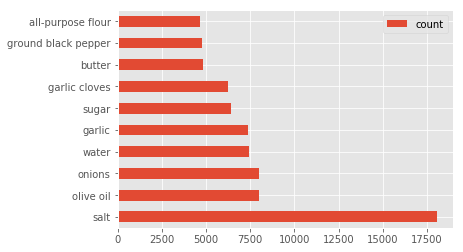

In [12]:
ingre_counts = pd.DataFrame(pd.Series(ingre_list).value_counts())
ingre_counts = ingre_counts[:10] # get top 10 ingredients that in every recipe
ingre_counts.columns = ["count"]
ingre_counts.plot(kind = "barh")

We can see that most of recipes need salt, oliver oil and onions

Since the Italian cuisine appears the most, let's see the top 10 ingredients in Italian recipe

In [13]:
italian_ingre = train_data.loc[train_data['cuisine'] == 'italian']['ingredients'].reset_index(drop = True) # list of all ingredients of intalian
ingre_italian = [] # change to a whole 1d arrray
for j in range(len(italian_ingre)):
    ingre_italian += italian_ingre[j]

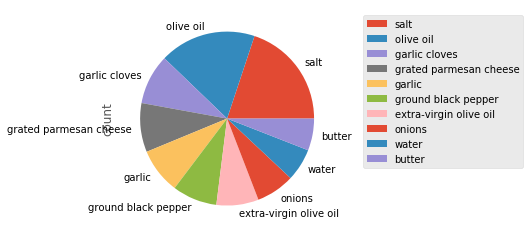

In [14]:
italian_counts = pd.DataFrame(pd.Series(ingre_italian).value_counts())[:10] # get top 10 ingredients
italian_counts.columns = ["count"]
italian_counts.plot(kind = "pie", y = "count", figsize = [15,4]).legend(bbox_to_anchor = (1.1,1)) # create a pie plot

The above pie plot is the top 10 most common ingredients in italian recipes.

In [15]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (25, 10)
train_data["total_ingre"] = train_data["ingredients"].apply(lambda x: len(x))
train_data.groupby("cuisine")["total_ingre"].max()

cuisine
brazilian       59
british         30
cajun_creole    31
chinese         38
filipino        38
french          31
greek           27
indian          49
irish           27
italian         65
jamaican        35
japanese        34
korean          29
mexican         52
moroccan        31
russian         25
southern_us     40
spanish         35
thai            40
vietnamese      31
Name: total_ingre, dtype: int64

The above list is the maximum ingredients required in each types of cuisine

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


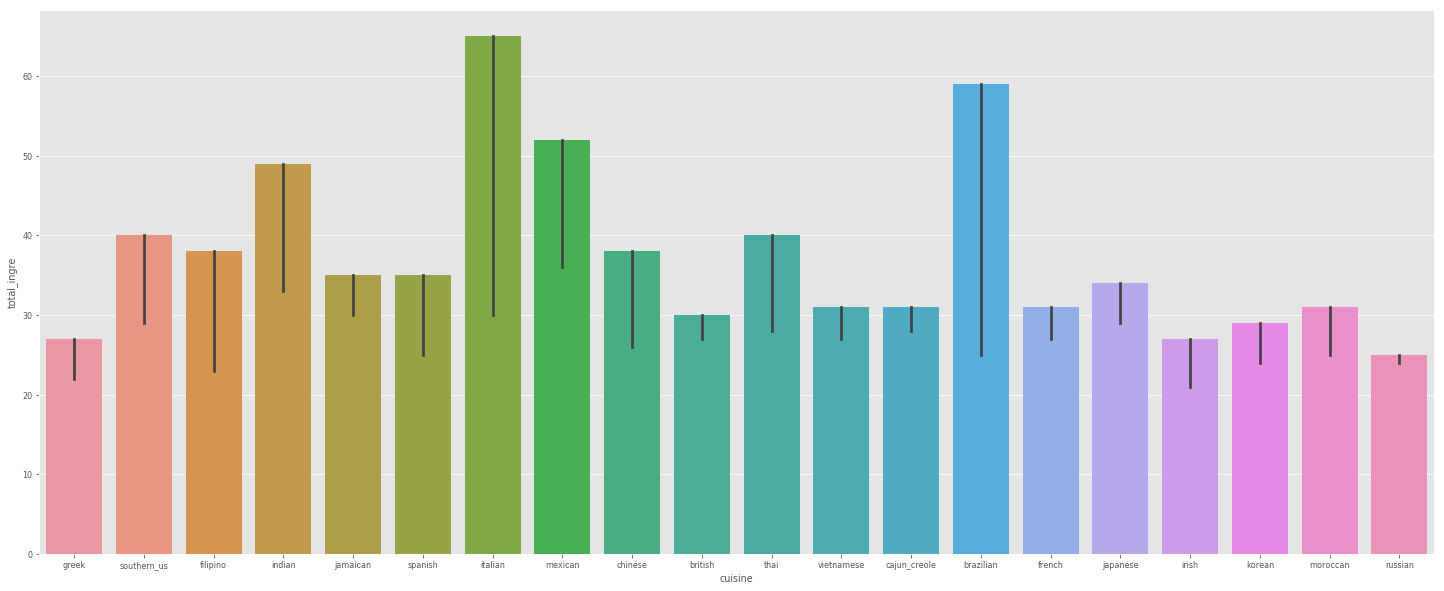

In [16]:
sns.barplot(x = "cuisine", y = "total_ingre", data = train_data, estimator = max)

Visualize result

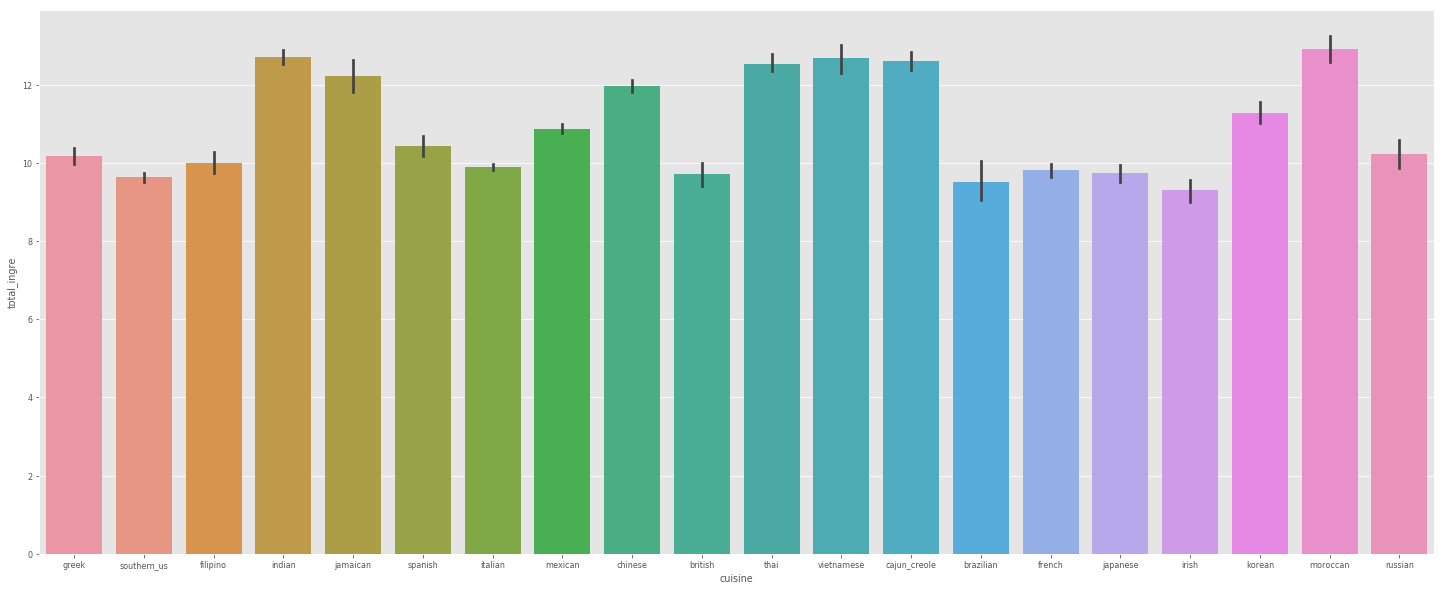

In [79]:
sns.barplot(x = "cuisine", y = "total_ingre", data = train_data) # default is mean

From the above figure, I could see that thai, vietnamese and cajun_creole have similar average ingredients for each recipe.

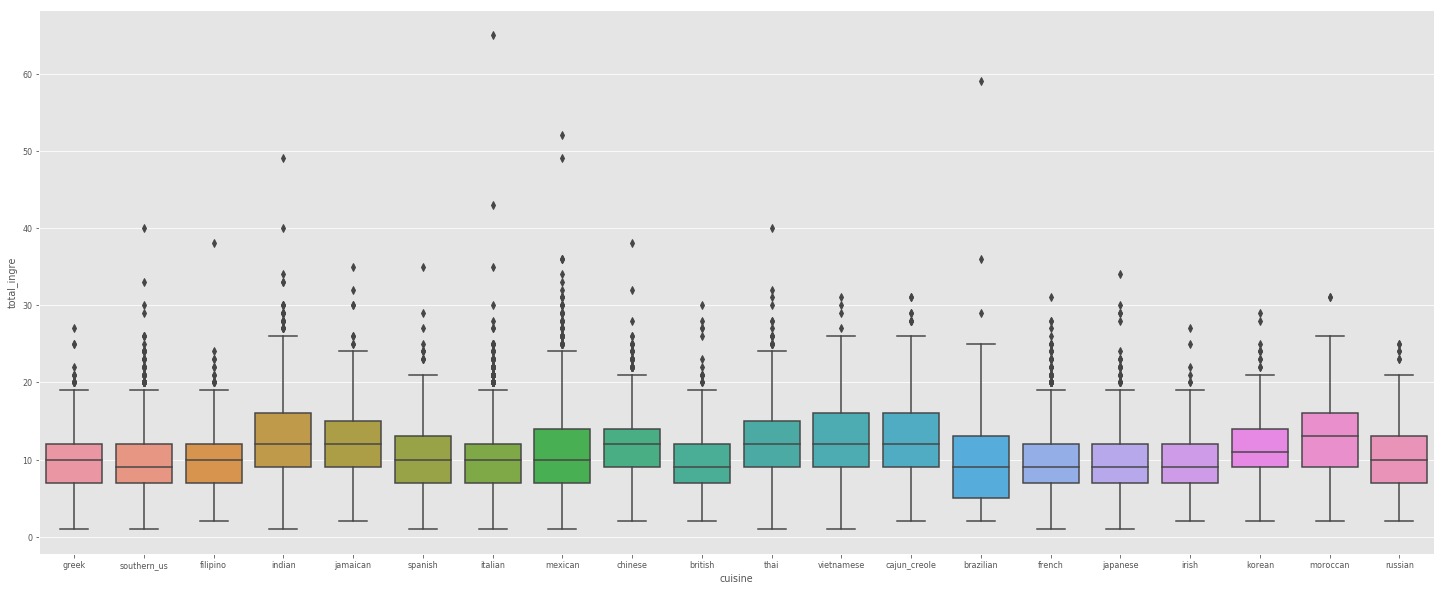

In [80]:
sns.boxplot(x = "cuisine", y = "total_ingre", data = train_data)

From above box plots for all types of cuisines, I could make several observations:
1. All cuisines have outliers.
2. Moroccan seems to have the longest recipe length in average comparing to all other cuisines. Furthermore, Moroccan has the fewest outlier.
3. Southern_US, British, French and Irish cuisine has the shortest recipe length and has more outliers.


We can also draw a violin plot, this kind of plot can tell us the outliers as well as the kernel distribution of each cuisine.

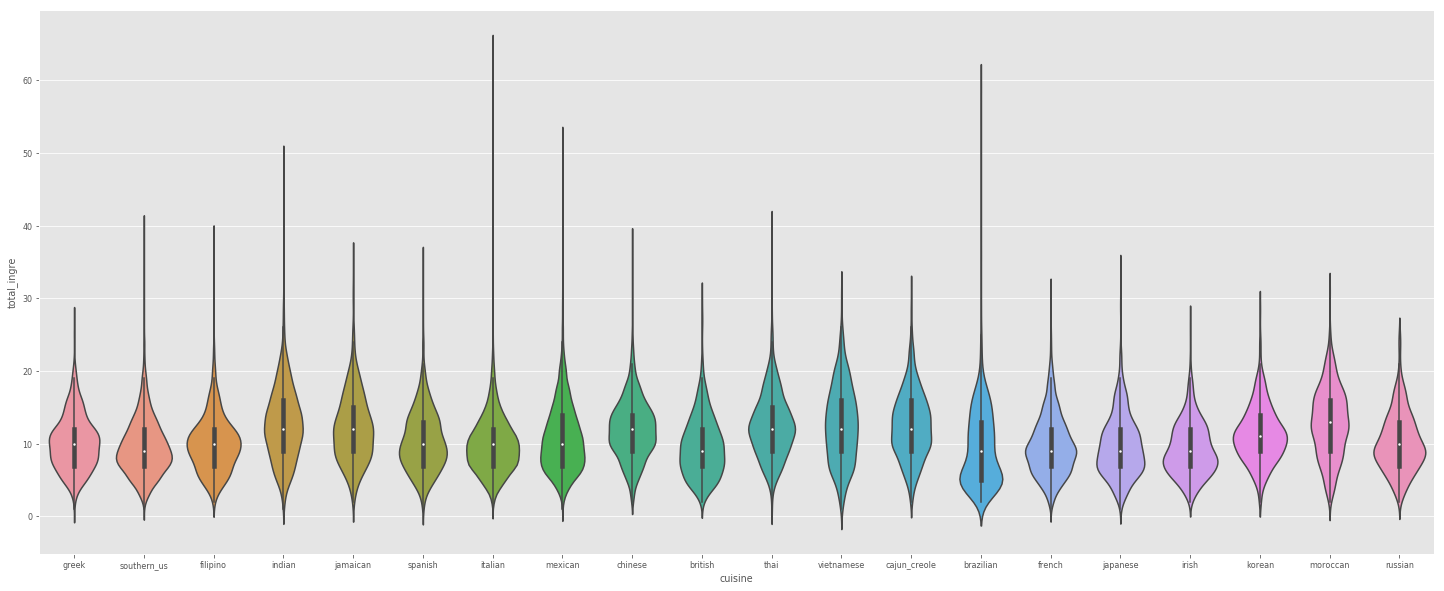

In [81]:
sns.violinplot(x = "cuisine", y = "total_ingre", data = train_data)

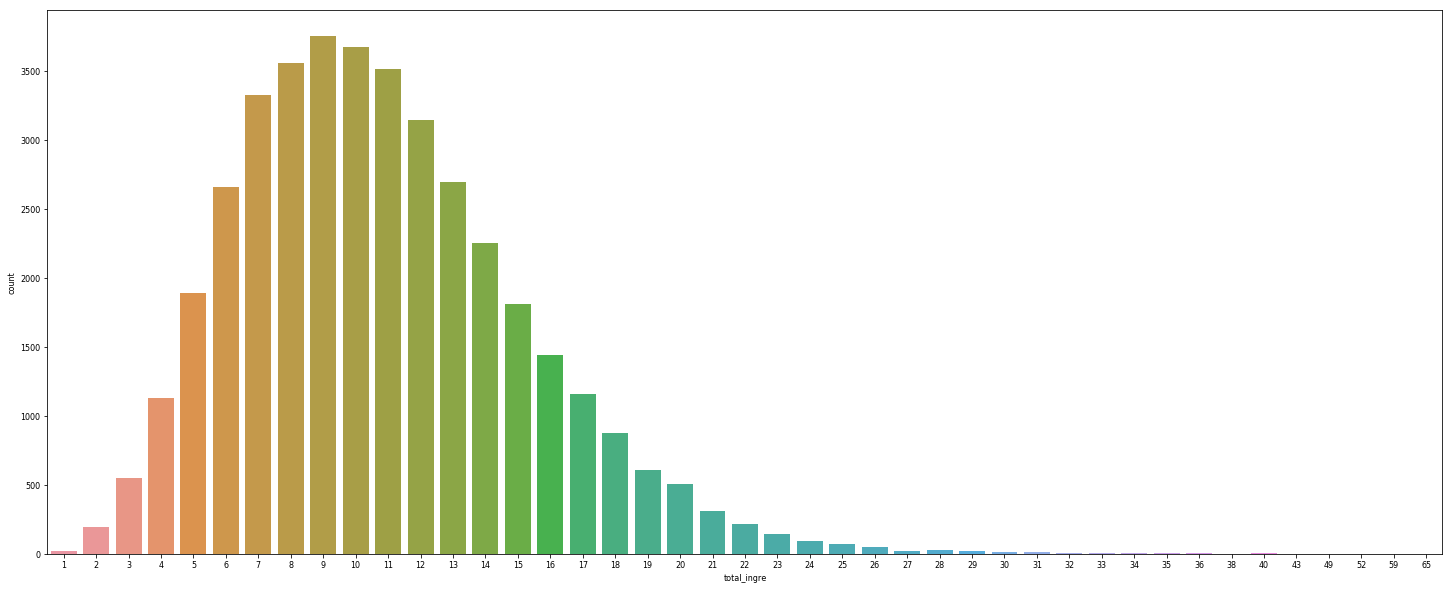

In [13]:
sns.countplot(x = "total_ingre", data = train_data)

In [18]:
print(train_data[train_data["total_ingre"] == 65]["ingredients"].values)
print(train_data[train_data["total_ingre"] == 65]["cuisine"].values)

[list(['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pepper', 'grated parmesan cheese', 'boneless skinless chicken brea

Notice that most of the recipes required around 10 ingredients. The max ingredients required are 65 different ingredients, which belongs to the italian cuisine. This may result a outlier for this dataset.

In [17]:
def parseWord(df, cuisine):
    rslt = []
    for ingredient in df[df["cuisine"] == cuisine]["ingredients"]:
        rslt += ingredient
    text = " ".join(rslt)
    wordCloud = WordCloud(background_color = "white", max_words = 60, width = 1000, height = 500).generate(text)
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word cloud for: " + cuisine)
    plt.show()

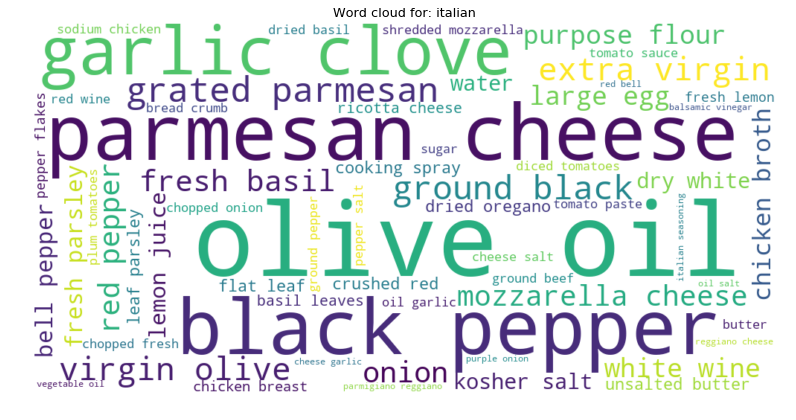

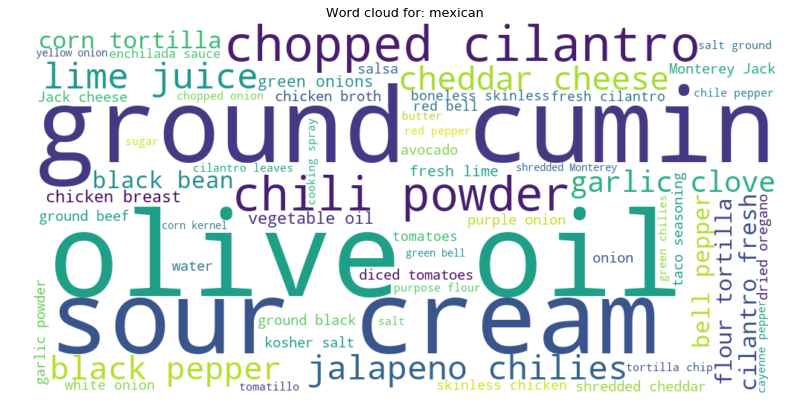

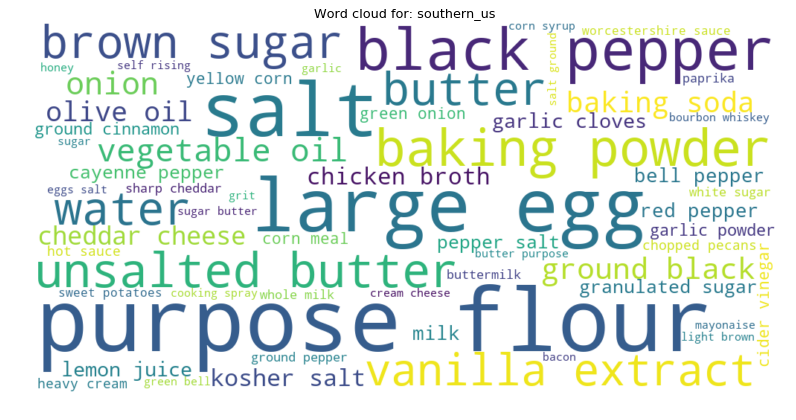

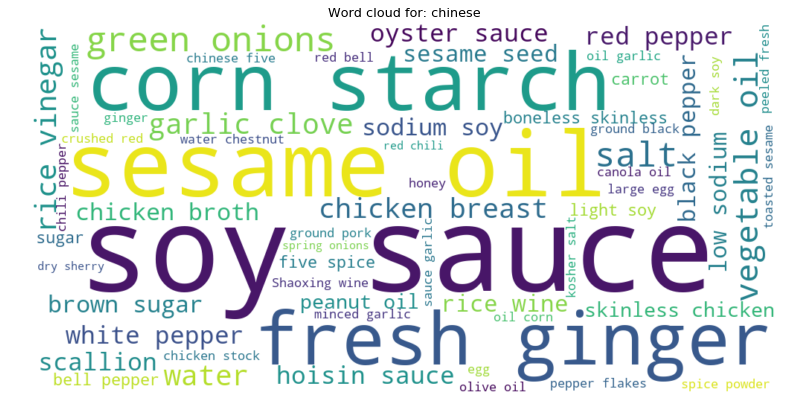

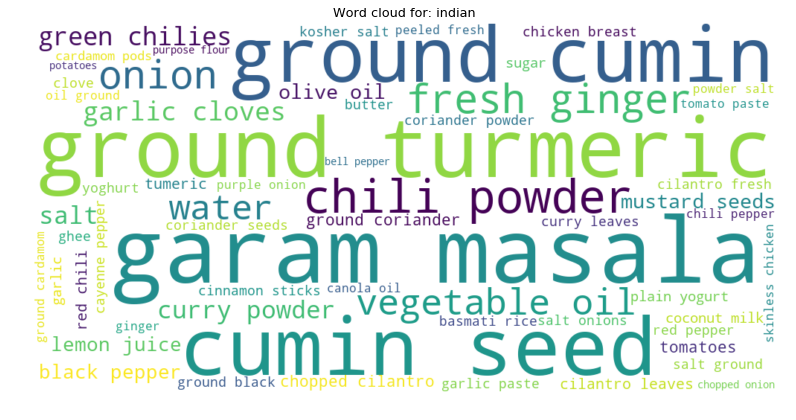

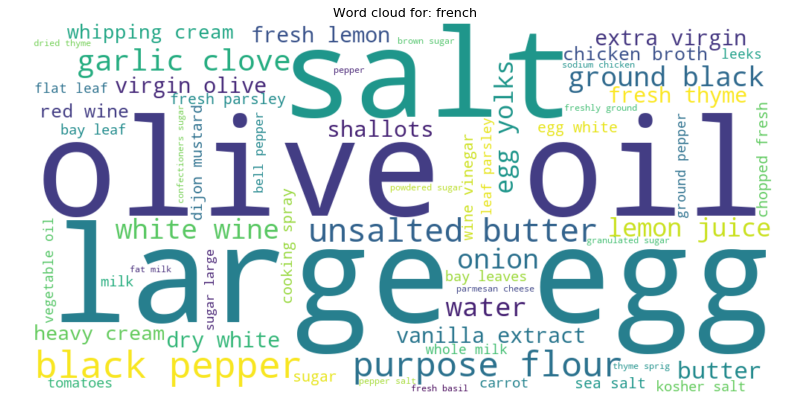

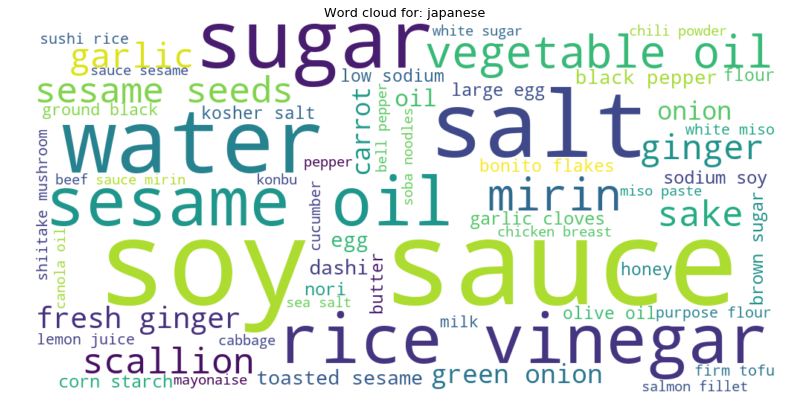

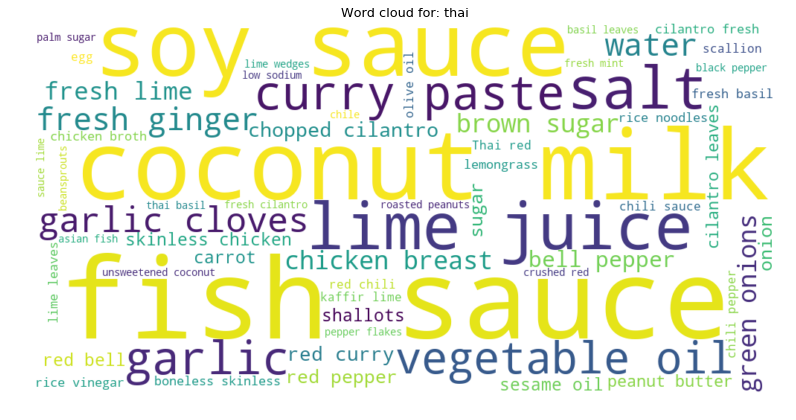

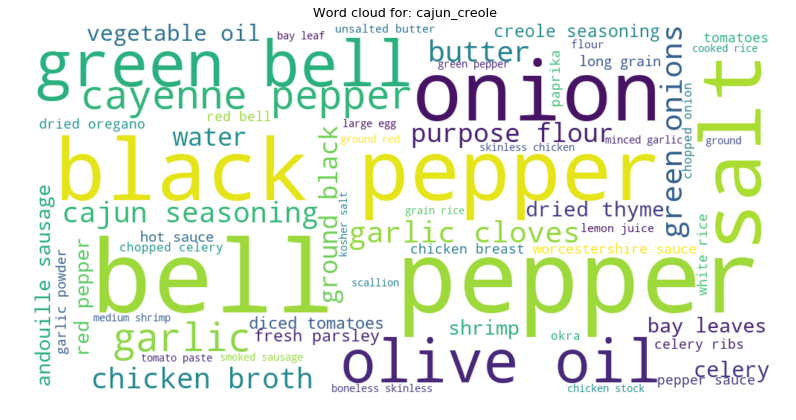

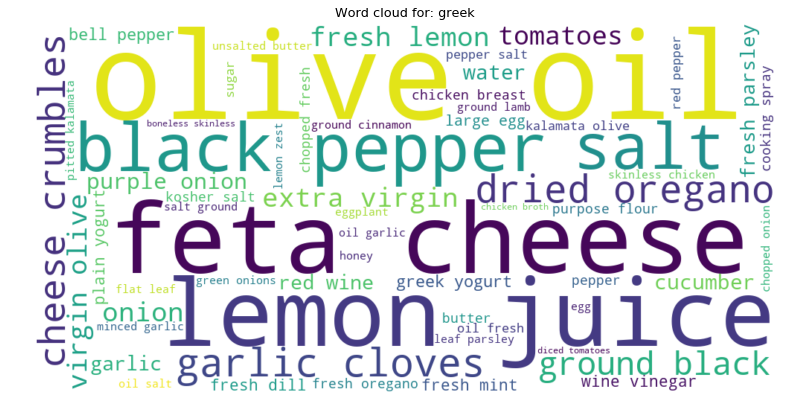

In [18]:
parseWord(train_data, 'italian')
parseWord(train_data, 'mexican')
parseWord(train_data, 'southern_us')
parseWord(train_data, 'chinese')
parseWord(train_data, 'indian')
parseWord(train_data, 'french')
parseWord(train_data, 'japanese')
parseWord(train_data, 'thai')
parseWord(train_data, 'cajun_creole')
parseWord(train_data, 'greek')

The wordcloud plot can tell me some important ingredients in the top 10 cuisine. 

I will look at ingredients more detailed, as those ingredients may occur in different tense. Same ingredient may appear in singular or plural and may contains special characters.

In [19]:
special_char = ' '
for char in set(' '.join(ingre_list)):
    if re.findall('[^A-Za-z]', char): # use regex to find special charactor
        special_char += char
sorted(special_char)

[' ',
 ' ',
 '!',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '®',
 'â',
 'ç',
 'è',
 'é',
 'í',
 'î',
 'ú',
 '’',
 '€',
 '™']

Some companies like to add special characters after each ingredients. Therefore, I have to remove those special characters before building model.

Some ingredients also contain numbers and units. Let's take a look.

In [20]:
special_number = set() 
for ingredient in ingre_list:
    if re.findall("[0-9]", ingredient): # find number appears in ingredients
        special_number.add(ingredient)
print(special_number)
print("length of ingredients contain number: ", len(special_number))

{'1% low-fat cottage cheese', '(10 oz.) frozen chopped spinach', 'Yoplait® Greek 2% caramel yogurt', 'evaporated low-fat 2% milk', '40% less sodium taco seasoning mix', 'KRAFT Mexican Style 2% Milk Finely Shredded Four Cheese', '2% low-fat cottage cheese', '7 Up', 'KNUDSEN 2% Milkfat Low Fat Cottage Cheese', '2% milk shredded mozzarella cheese', '40% less sodium taco seasoning', '2% low fat cheddar chees', '2% reduced-fat milk', 'Bengali 5 Spice', 'Tipo 00 flour', '2% lowfat greek yogurt', 'Yoplait® Greek 100 blackberry pie yogurt', 'mexican style 4 cheese blend', '33% less sodium ham', 'Sargento® Traditional Cut Shredded 4 Cheese Mexican', '25% less sodium chicken broth', '1% low-fat buttermilk', '1% low-fat milk', 'low sodium 96% fat free ham', '95% lean ground beef', 'v 8 juice', '33% less sodium smoked fully cooked ham', 'licor 43', '(14 oz.) sweetened condensed milk', '33% less sodium cooked deli ham', '2 1/2 to 3 lb. chicken, cut into serving pieces', '33% less sodium cooked ham'

From the above result, some ingredients contain number and units (like oz. ounc, lb.). Those number can be considered as quantitative factors, however, since there are only 40 of them, I will remove those numbers as well as units.

In [21]:
train_data[train_data["total_ingre"] == 1]["ingredients"].values

array([list(['sushi rice']), list(['dried rice noodles']),
       list(['plain low-fat yogurt']), list(['unsalted butter']),
       list(['udon']), list(['sticky rice']), list(['butter']),
       list(['corn tortillas']), list(['grained']),
       list(['lemonade concentrate']), list(['jasmine rice']),
       list(['unsalted butter']), list(['cherry tomatoes']),
       list(['butter']), list(['cumin seed']), list(['haricots verts']),
       list(['vegetable oil']), list(['spanish chorizo']),
       list(['sweetened condensed milk']), list(['water']),
       list(['phyllo']), list(['unsalted butter'])], dtype=object)

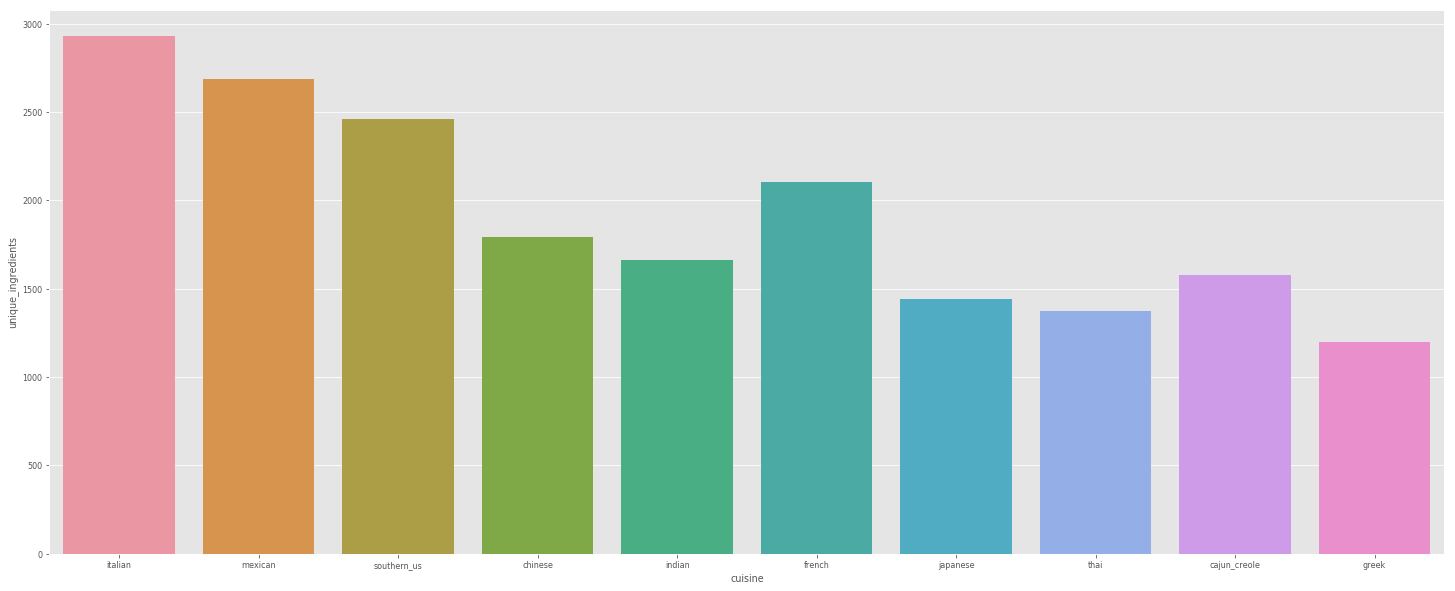

In [22]:
labels = ['italian', 'mexican', 'southern_us', 'chinese', 'indian', 'french', 'japanese', 'thai', 'cajun_creole', 'greek'] # top 10 cuisine in this dataset
unique_list = [] # find their unique ingredients
for cuisine in labels:
    temp = []
    for inglist in train_data[train_data["cuisine"] == cuisine]["ingredients"]:
        for ing in inglist:
            temp.append(ing) # get very word
    unique_list.append([cuisine, len(set(temp))]) # set() will eliminiate duplicates
unique_df = pd.DataFrame(unique_list, columns = ["cuisine", "unique_ingredients"])
unique_df.sort_values(by = "unique_ingredients")
sns.barplot(x = "cuisine", y = "unique_ingredients", data = unique_df)

## Feature Engineering

In this section, I will remove any outliers in this dataset, and then remove special characters, numbers and units as I discussed in previous section. Secondly I will change each ingredient into number for the model.

References:

1. https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string
2. https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string
3. https://www.cnblogs.com/jclian91/p/9898511.html



### Clean training and testing dataset

I will start with remove special characters, numbers and units for both training and testing dataset.

#### Training dataset:

In [23]:
wnl = WordNetLemmatizer()
def preprocessing(ingredients):
    ingredients_train = " ".join(ingredients)
    ingredients_train = ingredients_train.lower() # change to lower case
    ingredients_train = ingredients_train.replace("-", " ") # remove hypthen
    words = []
    for word in ingredients_train.split():
        word = re.sub("[0-9]"," ",word)
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), " ", word)
        word = unidecode.unidecode(word) # change to default accent, since ingredients are all noun, we do not need to specific type
        word = wnl.lemmatize(word)
        if len(word) > 0:
            words.append(word)
    return " ".join(words)

In [24]:
ingre_len = len(train_data["ingredients"])
train_data["features"] = " "
for i in range(ingre_len): # appply above function to each row in training dataset
    #ingre = train_no_outlier.loc[i, "ingredients"]
    result = preprocessing(train_data.loc[i, "ingredients"])
    train_data.loc[i, "features"] = result

train_data.head()

,cuisine,id,ingredients,total_ingre,features
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


In [129]:
train_no_outlier = train_data[(train_data["total_ingre"] > 1) & (train_data["total_ingre"] < 60)].reset_index(drop = True) # eliminate recipes 
#that requaired on eingredeint or 65 ingredients
train_no_outlier.head(10)

,cuisine,id,ingredients,total_ingre,features
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge...",12,plain flour sugar butter egg fresh ginger root...
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli...",13,olive oil salt medium shrimp pepper garlic cho...
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo...",10,sugar pistachio nut white almond bark flour va...
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por...",13,olive oil purple onion fresh pineapple pork po...
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-...",6,chopped tomato fresh basil garlic extra virgin...


In [ ]:
train_no_outlier.to_csv("train_data_cleaned.csv")

Write this cleaned dataframe to a csv file for futher use.

#### Testing Dataset:

In [131]:
ingre_test_len = len(test_data["ingredients"])
test_data["features"] = " "
for i in range(ingre_test_len):
    #ingre = train_no_outlier.loc[i, "ingredients"]
    result = preprocessing(test_data.loc[i, "ingredients"]) # apply this function to all rows in test dataset
    test_data.loc[i, "features"] = result

test_data.head()

,id,ingredients,features
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",baking powder egg all purpose flour raisin mil...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar egg yolk corn starch cream of tartar ban...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausage link fennel bulb frond olive oil cuban...
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",meat cut file powder smoked sausage okra shrim...
4,35687,"[ground black pepper, salt, sausage casings, l...",ground black pepper salt sausage casing leek p...


In [132]:
test_data.to_csv("test_data_cleaned.csv")

### Change text to numberic values using TF-IDF

In order to use ingredients in the model, I have to convert string values to numeric values so that the computer can do mathematical operations. There are many ways to convert string to numeric values, one popular method is one hot encoding. However, since each recipe just have a few ingredients in common(like salt, water, oil), the sparse matrix generated after one-hot encoding will be very large and will slow the calculation speed. The other method would be just extract some significant ingredients in each recipe. I will be using second method in this case. One way to extract important term in each recipe is to use TF-IDF(Term Frequency - Inverse Document Frequency). 

This method is intened to reflect the importance of a word is to a document, in this case, this method will give me the most important ingredients in each recipe. Moreover, using this method could also give a specific weight to each ingredient in the recipe. I could also use the result generated by TF-IDF to calculate cosine similarity in order to see how two recipes are similar to one another.

Reference: 
1. https://en.wikipedia.org/wiki/Tf%E2%80%93idf
2. http://www.ruanyifeng.com/blog/2013/03/tf-idf.html
3. https://blog.csdn.net/weixin_38278334/article/details/82971752

In [2]:
train_cleaned = pd.read_csv("train_data_cleaned.csv")
test_cleaned = pd.read_csv("test_data_cleaned.csv")

In [3]:
train_cleaned.head()

,Unnamed: 0,cuisine,id,ingredients,total_ingre,features
0,0,greek,10259,"['romaine lettuce', 'black olives', 'grape tom...",9,romaine lettuce black olive grape tomato garli...
1,1,southern_us,25693,"['plain flour', 'ground pepper', 'salt', 'toma...",11,plain flour ground pepper salt tomato ground b...
2,2,filipino,20130,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...",12,egg pepper salt mayonaise cooking oil green ch...
3,3,indian,22213,"['water', 'vegetable oil', 'wheat', 'salt']",4,water vegetable oil wheat salt
4,4,indian,13162,"['black pepper', 'shallots', 'cornflour', 'cay...",20,black pepper shallot cornflour cayenne pepper ...


In [4]:
train_cleaned = train_cleaned.drop(columns = ["Unnamed: 0", "ingredients", "total_ingre"], axis = 1)
train_cleaned.head()

,cuisine,id,features
0,greek,10259,romaine lettuce black olive grape tomato garli...
1,southern_us,25693,plain flour ground pepper salt tomato ground b...
2,filipino,20130,egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,water vegetable oil wheat salt
4,indian,13162,black pepper shallot cornflour cayenne pepper ...


In [5]:
test_cleaned = test_cleaned.drop(columns = ["Unnamed: 0", "ingredients"], axis = 1)
test_cleaned.head()

,id,features
0,18009,baking powder egg all purpose flour raisin mil...
1,28583,sugar egg yolk corn starch cream of tartar ban...
2,41580,sausage link fennel bulb frond olive oil cuban...
3,29752,meat cut file powder smoked sausage okra shrim...
4,35687,ground black pepper salt sausage casing leek p...


In [11]:
#vectorized = TfidfVectorizer(stop_words = "english", sublinear_tf = True)
vectorized = TfidfVectorizer(stop_words = "english", max_df = 0.85, min_df = 2, binary = True)

In [12]:
train_vect = vectorized.fit_transform(train_cleaned["features"].values) # transfer to numeri value
train_vect.sort_indices() # sort index
train_vect

<39751x2226 sparse matrix of type '<class 'numpy.float64'>'
	with 745053 stored elements in Compressed Sparse Row format>

In [13]:
#vectorized2 = TfidfVectorizer(stop_words = "english", sublinear_tf = True)

In [14]:
test_vect = vectorized.transform(test_cleaned["features"].values)
test_vect

<9944x2226 sparse matrix of type '<class 'numpy.float64'>'
	with 186689 stored elements in Compressed Sparse Row format>

In [15]:
label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_cleaned["cuisine"].values) # change from string to numeric label value
train_label.shape

(39751,)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_vect, train_label, test_size = 0.20, random_state = 0) # split training data to train and validate 

In [17]:
X_train_svd = X_train
X_valid_svd = X_valid
test_svd = test_vect

In [18]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(100) # reduce dimension

In [19]:
svd.fit_transform(X_train_svd)
svd.fit_transform(X_valid_svd)
svd.transform(test_svd)

array([[ 0.24261139,  0.53563215,  0.04319192, ...,  0.04605513,
        -0.01857315, -0.00330408],
       [ 0.13949823,  0.296211  ,  0.10673907, ..., -0.03336128,
        -0.06061046, -0.0268463 ],
       [ 0.10053079, -0.04840996, -0.05753605, ..., -0.05471365,
         0.04099592,  0.02077552],
       ...,
       [ 0.19277343,  0.1105289 , -0.12591516, ..., -0.13186041,
         0.06813093,  0.05427418],
       [ 0.3158246 , -0.01693579, -0.01133149, ...,  0.0538591 ,
         0.00660116, -0.04242684],
       [ 0.27697347, -0.08515854,  0.01003845, ...,  0.05215065,
        -0.10483676,  0.00825043]])

In [20]:
X_train_svd.shape

(31800, 2226)

In [21]:
scale = StandardScaler(with_mean = False)
X_train_scale = scale.fit_transform(X_train_svd) # standardize both training and test dataset for SVM algotithm
X_valid_scale = scale.fit_transform(X_valid_svd)
test_vect_scale = scale.transform(test_svd)

## Building Models

In this section, I will be perform three popular algorithms that fit this dataset.
1. Logistic Regression
2. Support Vector Machine
3. Multi-layer Perceptron

I will discuss why I choose those three algorithms, how to choose and tune hyperparameter for each model and finally the accuracy score in the test data.



### Logistic Regression

References: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

The first model I picked is logistic regression for the following reason:
1. Our task is a classification problem, even though it has 20 different classes for us to predict.
2. The OVR(One-Vs-Rest) options allow logistic regression to predict multiclasses case.
3. OVR logistic regression will train a separate model for each cuisine predicted whether an raw of ingredients belongs to that class or not 

Logistic Regression has following parameters I think are significant:
1. penalty: this parameter represents the specific norm used in penalization. The choices are "L1", "L2", "ElasticNet" and "None"
2. C: this is the inverse of regularization strength. Smaller C represents strong rugularization.

I choose C from a small value to a relative larger value, goes up 100 times for every value under 100. For panelty, I just include L1 norm and L2 norm. 

In [22]:
def print_results(results): # function for print hyperparameter value and model accuracy
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [46]:
lr = LogisticRegression() # initialize model
parameters = { # hyperparameter grid
    'C': [0.01, 0.1, 1, 10, 100, 200],
    'penalty': ['l1', 'l2']
}

cv = GridSearchCV(lr, parameters, n_jobs = -1) # will use default 3-fold cross validation
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'C': 10, 'penalty': 'l2'}

0.361 (+/-0.002) for {'C': 0.01, 'penalty': 'l1'}
0.478 (+/-0.003) for {'C': 0.01, 'penalty': 'l2'}
0.665 (+/-0.006) for {'C': 0.1, 'penalty': 'l1'}
0.669 (+/-0.003) for {'C': 0.1, 'penalty': 'l2'}
0.774 (+/-0.003) for {'C': 1, 'penalty': 'l1'}
0.768 (+/-0.006) for {'C': 1, 'penalty': 'l2'}
0.772 (+/-0.006) for {'C': 10, 'penalty': 'l1'}
0.784 (+/-0.007) for {'C': 10, 'penalty': 'l2'}
0.738 (+/-0.008) for {'C': 100, 'penalty': 'l1'}
0.764 (+/-0.005) for {'C': 100, 'penalty': 'l2'}
0.73 (+/-0.012) for {'C': 200, 'penalty': 'l1'}
0.757 (+/-0.005) for {'C': 200, 'penalty': 'l2'}


In [52]:
cv.best_estimator_ #get best estimator

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
logreg1 = LogisticRegression(C=10, penalty = 'l2', dual=False)
logreg1.fit(X_train , y_train)
logreg1.score(X_valid, y_valid)

0.7866934976732487

In [49]:
Y_test = logreg1.predict(test_vect) # predict value
test_label = label_encoder.inverse_transform(Y_test) # change back to string value
test_label[:20]

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['irish', 'southern_us', 'italian', 'cajun_creole', 'italian',
       'southern_us', 'french', 'chinese', 'mexican', 'british',
       'italian', 'greek', 'indian', 'italian', 'british', 'french',
       'mexican', 'southern_us', 'mexican', 'southern_us'], dtype=object)

In [50]:
test_id = test_cleaned["id"]
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label}, columns = ["id", "cuisine"])
submission.to_csv("sub_lr_test.csv", index = False)

### Support Vector Machine

Reference: https://xijunlee.github.io/2017/03/29/sklearn%E4%B8%ADSVM%E8%B0%83%E5%8F%82%E8%AF%B4%E6%98%8E%E5%8F%8A%E7%BB%8F%E9%AA%8C%E6%80%BB%E7%BB%93/


The second model I selected is Support Vector Machine(SVM). SVM is also a method for classification and it can be used under OneVsRest classifier function as well. Other advantages that SVM have:
1. It has a kenerl option which can transform the data and finds an optimal boundry between possible values. The kernerl option may perform very complexity data transformations, and then figure out how to seperate for different classes.
2. SVM could also be non-linear, this means the boundary does not have to be straight line. When the boundary is polynomial, the algorithm can capture more details and more complex relations between data and lables.

I decide to tuning support vector machine algorithm based on three parameters, which I think are also significant. 
1. C: same as C in logistic regression, it is the regularization paraemter. The panelty for support vector machine is squared L2 penalty. I do not have to tune penalty in SVM.
2. Kernel: kernel function for the algoritm, it may be linear, poly, rbf and sigmoid. Since linear function is a special type of rbf, I  just selected polynimial and rbf.
3. Degree: This parameter only works for polynomial kernel function. I selected some common degrees for this parameter.
4. Gamma: kernel coefficient for rbf and poly. Larger gamma value means fewer support vector features. 

rbf function: $K(xi,xj)=exp(−γ||xi−xj||2),γ>0$

In [39]:
svc = LinearSVC(multi_class = 'ovr', max_iter = 1500, dual = False) # use linear svm because of limitation of computability
parameters = {
    'C': [0.01, 0.03, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
svc_cv = GridSearchCV(svc, parameters, verbose = 2, n_jobs = -1)
svc_cv.fit(X_train_scale, y_train)

print_results(svc_cv)
#model_tunning.fit(X_train, y_train)  score_func=f1_score

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.8min finished


BEST PARAMS: {'C': 0.03, 'penalty': 'l1'}

0.767 (+/-0.007) for {'C': 0.01, 'penalty': 'l1'}
0.755 (+/-0.004) for {'C': 0.01, 'penalty': 'l2'}
0.775 (+/-0.004) for {'C': 0.03, 'penalty': 'l1'}
0.746 (+/-0.003) for {'C': 0.03, 'penalty': 'l2'}
0.763 (+/-0.004) for {'C': 0.1, 'penalty': 'l1'}
0.738 (+/-0.005) for {'C': 0.1, 'penalty': 'l2'}
0.735 (+/-0.007) for {'C': 1, 'penalty': 'l1'}
0.721 (+/-0.009) for {'C': 1, 'penalty': 'l2'}
0.719 (+/-0.013) for {'C': 10, 'penalty': 'l1'}
0.714 (+/-0.012) for {'C': 10, 'penalty': 'l2'}


In [40]:
linearsvm = LinearSVC(C=0.03, penalty = 'l1', multi_class='ovr', dual = False, max_iter = 1500)
linearsvm.fit(X_train_scale, y_train)

LinearSVC(C=0.03, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1500,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [41]:
linearsvm.score(X_valid_scale, y_valid)

0.7834234687460697

In [42]:
Y_test_svm = linearsvm.predict(test_vect_scale)
test_label_svm = label_encoder.inverse_transform(Y_test_svm)
test_id = test_cleaned["id"]
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label_svm}, columns = ["id", "cuisine"])
submission.to_csv("sub_svm_test.csv", index = False)

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Multi-layer Perceptron

Reference: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

The third model I selected is multiple layer perceptron(MLP). This is a method under Scikit learn neural network package. Multilayer Perceptron is a supervised leanrning algorithm and it is a types of neural networks. The algorithm contains several layers: input layer, hidden layer(s) and output layer. 

Input layer represents the input features; each neuron in the hidden layer transforms the values from previous layer with a weight linear summation and activated by a function, usually this function is not linear. The most common activation functions are ReLu, Tanh and sigmoid(logistic). The output layer contains the value we want to predict. In this case, the input layer would be features generated by TF-IDF method and output layer would be 20 classes that we want to predict.

There are some advantages of Multilayer Perceptron:
1. This algorithm can learn non-linear models.
2. The MLP Classifier implements MLP algorithm using back propagation. 

In [17]:
mlp = MLPClassifier() # initialize model
parameters = {
    'hidden_layer_sizes': [(50,20), (100,40)], # hyperparameter tuning using GridSearch
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

mlp_cv = GridSearchCV(mlp, parameters, verbose = 2, n_jobs = -1) # using default 3-fold cv
mlp_cv.fit(X_train_scale, y_train)

print_results(mlp_cv)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 40.8min finished


BEST PARAMS: {'activation': 'logistic', 'hidden_layer_sizes': (100, 40), 'learning_rate': 'constant'}

0.715 (+/-0.013) for {'activation': 'relu', 'hidden_layer_sizes': (50, 20), 'learning_rate': 'constant'}
0.722 (+/-0.01) for {'activation': 'relu', 'hidden_layer_sizes': (50, 20), 'learning_rate': 'invscaling'}
0.72 (+/-0.006) for {'activation': 'relu', 'hidden_layer_sizes': (50, 20), 'learning_rate': 'adaptive'}
0.734 (+/-0.014) for {'activation': 'relu', 'hidden_layer_sizes': (100, 40), 'learning_rate': 'constant'}
0.737 (+/-0.004) for {'activation': 'relu', 'hidden_layer_sizes': (100, 40), 'learning_rate': 'invscaling'}
0.729 (+/-0.013) for {'activation': 'relu', 'hidden_layer_sizes': (100, 40), 'learning_rate': 'adaptive'}
0.723 (+/-0.002) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 20), 'learning_rate': 'constant'}
0.724 (+/-0.002) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 20), 'learning_rate': 'invscaling'}
0.724 (+/-0.007) for {'activation': 'tanh', 'hidde

In [18]:
mlp = MLPClassifier(hidden_layer_sizes = (100,40), activation = 'logistic', learning_rate = 'constant')
mlp_model = OneVsRestClassifier(mlp, n_jobs = -1)
mlp_model.fit(X_train_scale, y_train)

OneVsRestClassifier(estimator=MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 40), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
          n_jobs=-1)

In [19]:
mlp_model.score(X_valid_scale, y_valid) # valid on validation set

0.7714752861275311

In [20]:
Y_pred = mlp_model.predict(test_vect_scale)
test_label = label_encoder.inverse_transform(Y_pred)
test_label[:10]

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['russian', 'southern_us', 'italian', 'cajun_creole', 'italian',
       'southern_us', 'french', 'chinese', 'mexican', 'irish'],
      dtype=object)

In [21]:
test_id = test_cleaned["id"]
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label}, columns = ["id", "cuisine"])
submission.to_csv("sub_nn_test.csv", index = False)

In [29]:
mlp2 = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(500,200,40), (300,100,40)], # tuning for three hidden layers
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

mlp_cv2 = GridSearchCV(mlp2, parameters, verbose = 2, n_jobs = -1)
mlp_cv2.fit(X_train_scale, y_train)

print_results(mlp_cv2)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 150.3min finished


BEST PARAMS: {'activation': 'relu', 'hidden_layer_sizes': (500, 200, 40), 'learning_rate': 'invscaling'}

0.74 (+/-0.009) for {'activation': 'relu', 'hidden_layer_sizes': (500, 200, 40), 'learning_rate': 'constant'}
0.746 (+/-0.011) for {'activation': 'relu', 'hidden_layer_sizes': (500, 200, 40), 'learning_rate': 'invscaling'}
0.743 (+/-0.014) for {'activation': 'relu', 'hidden_layer_sizes': (500, 200, 40), 'learning_rate': 'adaptive'}
0.736 (+/-0.019) for {'activation': 'relu', 'hidden_layer_sizes': (300, 100, 40), 'learning_rate': 'constant'}
0.738 (+/-0.02) for {'activation': 'relu', 'hidden_layer_sizes': (300, 100, 40), 'learning_rate': 'invscaling'}
0.742 (+/-0.014) for {'activation': 'relu', 'hidden_layer_sizes': (300, 100, 40), 'learning_rate': 'adaptive'}
0.739 (+/-0.017) for {'activation': 'tanh', 'hidden_layer_sizes': (500, 200, 40), 'learning_rate': 'constant'}
0.729 (+/-0.006) for {'activation': 'tanh', 'hidden_layer_sizes': (500, 200, 40), 'learning_rate': 'invscaling'}
0.

In [30]:
mlp2 = MLPClassifier(hidden_layer_sizes = (500, 200, 40), activation = 'relu', learning_rate = 'invscaling')
mlp_model2 = OneVsRestClassifier(mlp2, n_jobs = -1)
mlp_model2.fit(X_train_scale, y_train)

OneVsRestClassifier(estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(500, 200, 40), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
          n_jobs=-1)

In [33]:
mlp_model2.score(X_valid_scale, y_valid) # valid on validation set

0.7780153439818891

In [34]:
Y_pred = mlp_model2.predict(test_vect_scale)
test_label = label_encoder.inverse_transform(Y_pred)
test_label[:10]

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['irish', 'southern_us', 'italian', 'cajun_creole', 'italian',
       'southern_us', 'french', 'chinese', 'mexican', 'irish'],
      dtype=object)

In [35]:
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label}, columns = ["id", "cuisine"])
submission.to_csv("sub_nn2_test.csv", index = False)

### Voting Classifier

In [50]:
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C=10,penalty = 'l2', dual=False)),('clf2',LinearSVC(C=0.03, penalty = 'l1', multi_class='ovr', dual = False, max_iter = 1500))],voting='hard',weights=[1,2], n_jobs = -1)
vclf.fit(X_train_scale, y_train) # majority voting

VotingClassifier(estimators=[('clf1', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('clf2', Line...ax_iter=1500,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=[1, 2])

In [51]:
vclf.score(X_valid_scale, y_valid)

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7832976984027167

In [47]:
combined = vclf.predict(test_vect_scale)
test_label_com = label_encoder.inverse_transform(combined)
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label_com}, columns = ["id", "cuisine"])
submission.to_csv("sub_combined_test.csv", index = False)

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Other models, not used in this project

In [ ]:
xgb = XGBClassifier(subsample = 0.7, gamma = 7)
parameters = {
    'eta': [0.003, 0.01, 0.03, 0.1],
    'max_depth': [3, 6, 9],
    'n_estimators': [500, 750, 1000]
}
xgb_cv = GridSearchCV(xgb, parameters, verbose = 2, n_jobs = -1)
xgb_cv.fit(X_train, y_train)

print_results(xgb_cv)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [46]:
rf = RandomForestClassifier(n_estimators = 700, max_depth = 32) #要调max features
parameters = {
    'min_samples_split': [50, 100],
    'max_features': [20, 30, 40],
    'min_samples_leaf': [20, 40, 50]
}

rf_cv = GridSearchCV(rf, parameters, verbose = 2, n_jobs = -1)
rf_cv.fit(X_train_svd, y_train)

print_results(rf_cv)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 11.4min finished


BEST PARAMS: {'max_features': 40, 'min_samples_leaf': 20, 'min_samples_split': 50}

0.538 (+/-0.005) for {'max_features': 20, 'min_samples_leaf': 20, 'min_samples_split': 50}
0.537 (+/-0.001) for {'max_features': 20, 'min_samples_leaf': 20, 'min_samples_split': 100}
0.49 (+/-0.006) for {'max_features': 20, 'min_samples_leaf': 40, 'min_samples_split': 50}
0.487 (+/-0.001) for {'max_features': 20, 'min_samples_leaf': 40, 'min_samples_split': 100}
0.462 (+/-0.0) for {'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 50}
0.465 (+/-0.003) for {'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 100}
0.566 (+/-0.001) for {'max_features': 30, 'min_samples_leaf': 20, 'min_samples_split': 50}
0.565 (+/-0.0) for {'max_features': 30, 'min_samples_leaf': 20, 'min_samples_split': 100}
0.534 (+/-0.002) for {'max_features': 30, 'min_samples_leaf': 40, 'min_samples_split': 50}
0.536 (+/-0.005) for {'max_features': 30, 'min_samples_leaf': 40, 'min_samples_split': 100}
0.521 

In [24]:
print_results(rf_cv)

BEST PARAMS: {'max_depth': 32, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 700}

0.501 (+/-0.004) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 300}
0.501 (+/-0.003) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 500}
0.503 (+/-0.001) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 700}
0.503 (+/-0.012) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 100}
0.504 (+/-0.002) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 300}
0.503 (+/-0.006) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 500}
0.502 (+/-0.003) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 700}
0.502 (+/-0.007) for {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 100}
0.495 (+/-0.002) for {'max_dep

In [48]:
rf_classifier = RandomForestClassifier(n_estimators = 700, max_depth = 32, min_samples_leaf = 20, min_samples_split = 50, max_features = 40)
ovr_rf = OneVsRestClassifier(rf_classifier, n_jobs = -1)
ovr_rf.fit(X_train_svd, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=-1)

In [49]:
ovr_rf.score(X_valid_svd, y_valid)

0.6479688089548484

In [30]:
Y_test_rf = ovr_rf.predict(test_vect)
test_label_rf = label_encoder.inverse_transform(Y_test_rf)
test_label_rf[:20]

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['southern_us', 'southern_us', 'italian', 'cajun_creole', 'italian',
       'southern_us', 'italian', 'chinese', 'mexican', 'southern_us',
       'italian', 'italian', 'indian', 'italian', 'southern_us',
       'italian', 'southern_us', 'southern_us', 'mexican', 'southern_us'],
      dtype=object)

In [31]:
test_id = test_cleaned["id"]
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label_rf}, columns = ["id", "cuisine"])
submission.to_csv("sub_rf_test.csv", index = False)